# Single-Frame Floc Analysis

This page shows an example of doing an analysis of the watercolumn floc for a single frame.

#### Setup your environment

In [60]:
%matplotlib inline
import pycamhd.pycamhd as camhd
import numpy as np
import matplotlib.pyplot as plt

#### Define filename and frame_number

In [61]:
filename = 'https://rawdata.oceanobservatories.org/files/RS03ASHS/PN03B/06-CAMHDA301/2016/07/30/CAMHDA301-20160730T090000Z.mov'
frame_number = 1959

#### Show frame as RGB24 and a rectangle showing the region of interest (ROI)

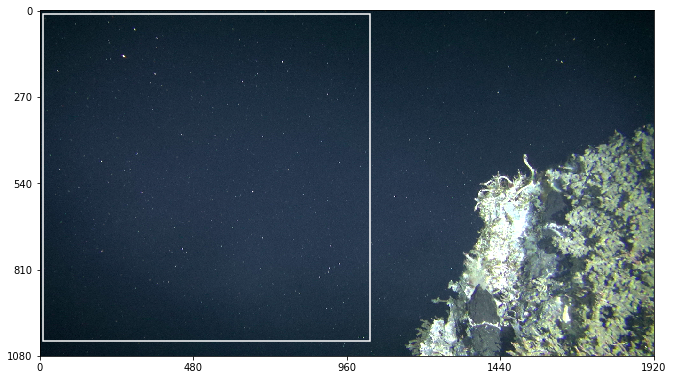

In [62]:
import matplotlib.patches as patches
plt.rc('figure', figsize=(11, 11))
frame = camhd.get_frame(filename, frame_number, 'rgb24')
fig, ax = plt.subplots();
im1 = ax.imshow(frame);
im1.set_cmap('gray');
plt.yticks(np.arange(0,1081,270))
plt.xticks(np.arange(0,1921,480));

# ROI
rect = patches.Rectangle((10,10),1024,1024,linewidth=1.5,edgecolor='w',facecolor='none');
ax.add_patch(rect);
plt.show();

#### Create the filter for filtering images in the frequency domain
To deal with variations in lighting and high-frequency noise, we filter each subimage using a Butterworth bandpass filter.

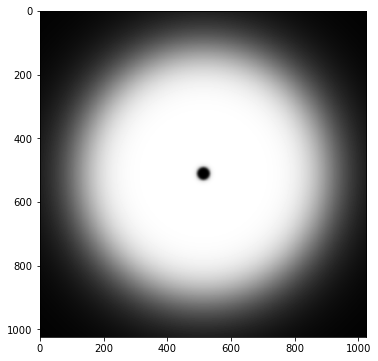

In [54]:
plt.rc('figure', figsize=(6, 6))
d1 = 20; # low cut wavenumber
d2 = 400; # high cut wavenumber
n = 4;
x = np.arange(-1024/2+0.5,1024/2+1-0.5)
xx, yy = np.meshgrid(x, x)
d = np.sqrt(xx**2+yy**2);
bff = (1 - (1./(1 + (d/d1)**(2*n))))*(1/(1 + (d/d2)**(2*n))); # Butterworth bandpass filter
imgplot = plt.imshow(bff, cmap='gray')

#### Define floc function and calculate floc value

In [55]:
def get_floc_proxy(frame):
    I = frame[0:1024, 0:1024]
    I_fft = np.fft.fft2(I);
    I_fft_shift = np.fft.fftshift(I_fft);
    I_fft_shift_filt = I_fft_shift*bff; # filter with the Butterworth filter
    I_fft_filt = np.fft.ifftshift(I_fft_shift_filt);
    I_filt = np.fft.ifft2(I_fft_filt);
    return (np.absolute(I_filt)>4000).sum(), I_filt

In [56]:
frame = camhd.get_frame(filename, frame_number, 'gray16le')
floc_value, I_filt = get_floc_proxy(frame)
print(floc_value)

4581


#### Show filtered image and write PNG

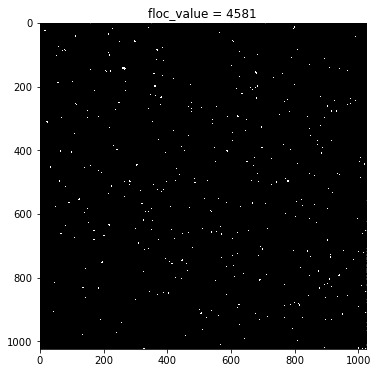

In [59]:
imgplot = plt.imshow(I_filt>4000, cmap='gray')
plt.title('floc_value = %i' % floc_value);

In [74]:
from numpngw import write_png
png_file = 'single_floc_image.png'
write_png(png_file, np.uint8((I_filt>4000)*255))